In [1]:
import sys

In [2]:
sys.version

'3.13.5 (main, Jun 11 2025, 15:36:57) [Clang 17.0.0 (clang-1700.0.13.3)]'

In [3]:
sys._is_gil_enabled()

True

In [4]:
import multiprocess
from functools import partial
from multiprocessing.shared_memory import SharedMemory
from multiprocessing.managers import SharedMemoryManager

import matplotlib.pyplot as plt
import numpy as np

## Find the shortest path between nodes in a graph

In this example, we'll search for a path between two nodes in a graph, represented by an adjacency matrix. The graph used below is very large, so copying it to each process either fills memory or takes a significant amount of time, so we'll use shared memory.

In [5]:
def path_distance(ij, adj_mat: np.ndarray, max_dist=5) -> int:
    """Find the path distance between nodes `i` and `j` on a graph described by an adjacency matrix, `adj_mat`.
    Give up after `max_dist` edge traversals.

    Parameters
    ----------
    ij : tuple of int
        Pair of node indices `(i, j)` between which to find the path.
    adj_mat : np.ndarray
        Adjacency matrix representing the graph.
    max_dist : int, optional
        Maximum number of edge traversals to search for a path (default is 5).

    Returns
    -------
    int
        Number of steps (less than or equal to `max_dist`) between nodes `i` and `j`.
        Returns -1 if no path found within the allowed number of steps.

    """
    i, j = ij
    if i == j:
        return 0
    step = 1
    connections = adj_mat[i, :]
    # import pdb; pdb.set_trace()
    while step < max_dist:
        if connections[j] > 0:
            return step
        step += 1
        connections = connections @ adj_mat
    return -1

In [6]:
def path_distance_shm(ij, adj_mat_shm: SharedMemory, max_dist=5) -> int:
    """Run the same path_distance calculation, but using a SharedMemory adjacency matrix."""

    # Don't bother setting up the big adjacency matrix if i==j, return distance of 0 immediately
    i, j = ij
    if i == j:
        return 0
    adj_mat = np.ndarray(shape=(M, M), dtype=np.uint8, buffer=adj_mat_shm.buf)
    return path_distance((i, j), adj_mat, max_dist)

In [7]:
M = int(5e4)
# M = 10
N = M * M
np.random.seed(0)
a1 = (np.random.rand(M, M) < 0.0005).astype(np.uint8)

In [8]:
# Adjacency matrix takes up 2.5 GB in memory
N / 1e9, a1.nbytes / 1e9

(2.5, 2.5)

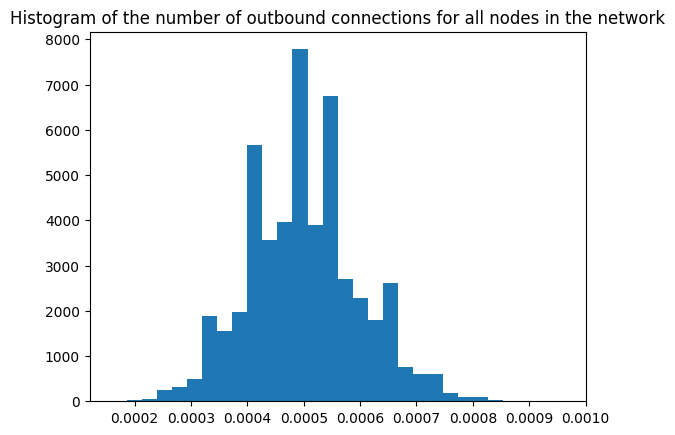

In [9]:
plt.figure()
plt.hist(a1.sum(axis=1) / M, 30)
plt.title('Histogram of the number of outbound connections for all nodes in the network')
plt.show()

In [10]:
%%time
path_distance((5, 10), a1)

CPU times: user 16.4 s, sys: 133 ms, total: 16.5 s
Wall time: 16.5 s


4

In [11]:
%%time
path_distance((4, 15), a1)

CPU times: user 16.8 s, sys: 173 ms, total: 17 s
Wall time: 17 s


4

In [12]:
%%time
distances = [path_distance((i, j), a1) for i in range(4) for j in range(4)]

CPU times: user 3min 10s, sys: 954 ms, total: 3min 11s
Wall time: 3min 11s


In [13]:
dict(sorted(zip(*np.unique(distances, return_counts=True)), key=lambda tup: tup[1], reverse=True))

{np.int64(4): np.int64(10), np.int64(0): np.int64(4), np.int64(3): np.int64(2)}

In [14]:
multiprocess.cpu_count()

16

In [15]:
%%time
with SharedMemoryManager() as smm:
    a1_shm = smm.SharedMemory(size=N)
    a1_buf = np.ndarray(shape=(M, M), dtype=np.uint8, buffer=a1_shm.buf)
    a1_buf[:] = a1[:]
    f = partial(path_distance_shm, adj_mat_shm=a1_shm)
    with multiprocess.Pool() as p:
        distances_par = p.map(f, ((i, j) for i in range(4) for j in range(4)))

CPU times: user 72.1 ms, sys: 140 ms, total: 212 ms
Wall time: 1min 24s


In [16]:
dict(sorted(zip(*np.unique(distances_par, return_counts=True)), key=lambda tup: tup[1], reverse=True))

{np.int64(4): np.int64(10), np.int64(0): np.int64(4), np.int64(3): np.int64(2)}

Running this over the process pool cut the time down by more than half, so that's an improvement. This is even faster in free-threaded python, though not because of speedups in the path_distance function, but because of removing the overhead of spawning/forking new workers.